In [1]:
import colour
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def create_theta_array(height, width, angle_of_view):
    x = np.arange(-width//2, width//2)
    y = np.arange(-height//2, height//2)
    z = np.sqrt(x[-1]**2 + y[-1]**2) / np.tan(angle_of_view)
    X, Y = np.meshgrid(x, y)
    return np.arctan(np.sqrt(X**2 + Y**2) / z)

def transform_wavelength(wavelength, beta, THETA):
    gamma = 1 / np.sqrt(1 - beta ** 2)
    return wavelength / (gamma * (1 - beta * np.cos(THETA)))

def wavelength_to_rgb(wavelength):
    visible_wavelength = np.clip(wavelength, 380, 750)
    xyz = colour.wavelength_to_XYZ(visible_wavelength)
    rgb = colour.XYZ_to_sRGB(xyz)
    return np.clip(rgb, 0, 1)

def transform_pixels(rgb_channels, rgb_trans):
    pixels_trans = 0
    for i in range(3):
        pixels_trans += rgb_trans[i] * rgb_channels[:, :, i][..., np.newaxis]
    return pixels_trans.astype(int)

In [11]:
angle_of_view = np.radians(13) # angle of view of 13° for a 50mm shot
beta = -0.15
red_wavelength, green_wavelength, blue_wavelength = 644, 515, 467.83

height, width = 5284, 3523

THETA = create_theta_array(height, width, angle_of_view)

red_wavelength_trans = transform_wavelength(red_wavelength, beta, THETA)
green_wavelength_trans = transform_wavelength(green_wavelength, beta, THETA)
blue_wavelength_trans = transform_wavelength(blue_wavelength, beta, THETA)

red_rgb_trans = wavelength_to_rgb(red_wavelength_trans)
green_rgb_trans = wavelength_to_rgb(green_wavelength_trans)
blue_rgb_trans = wavelength_to_rgb(blue_wavelength_trans)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


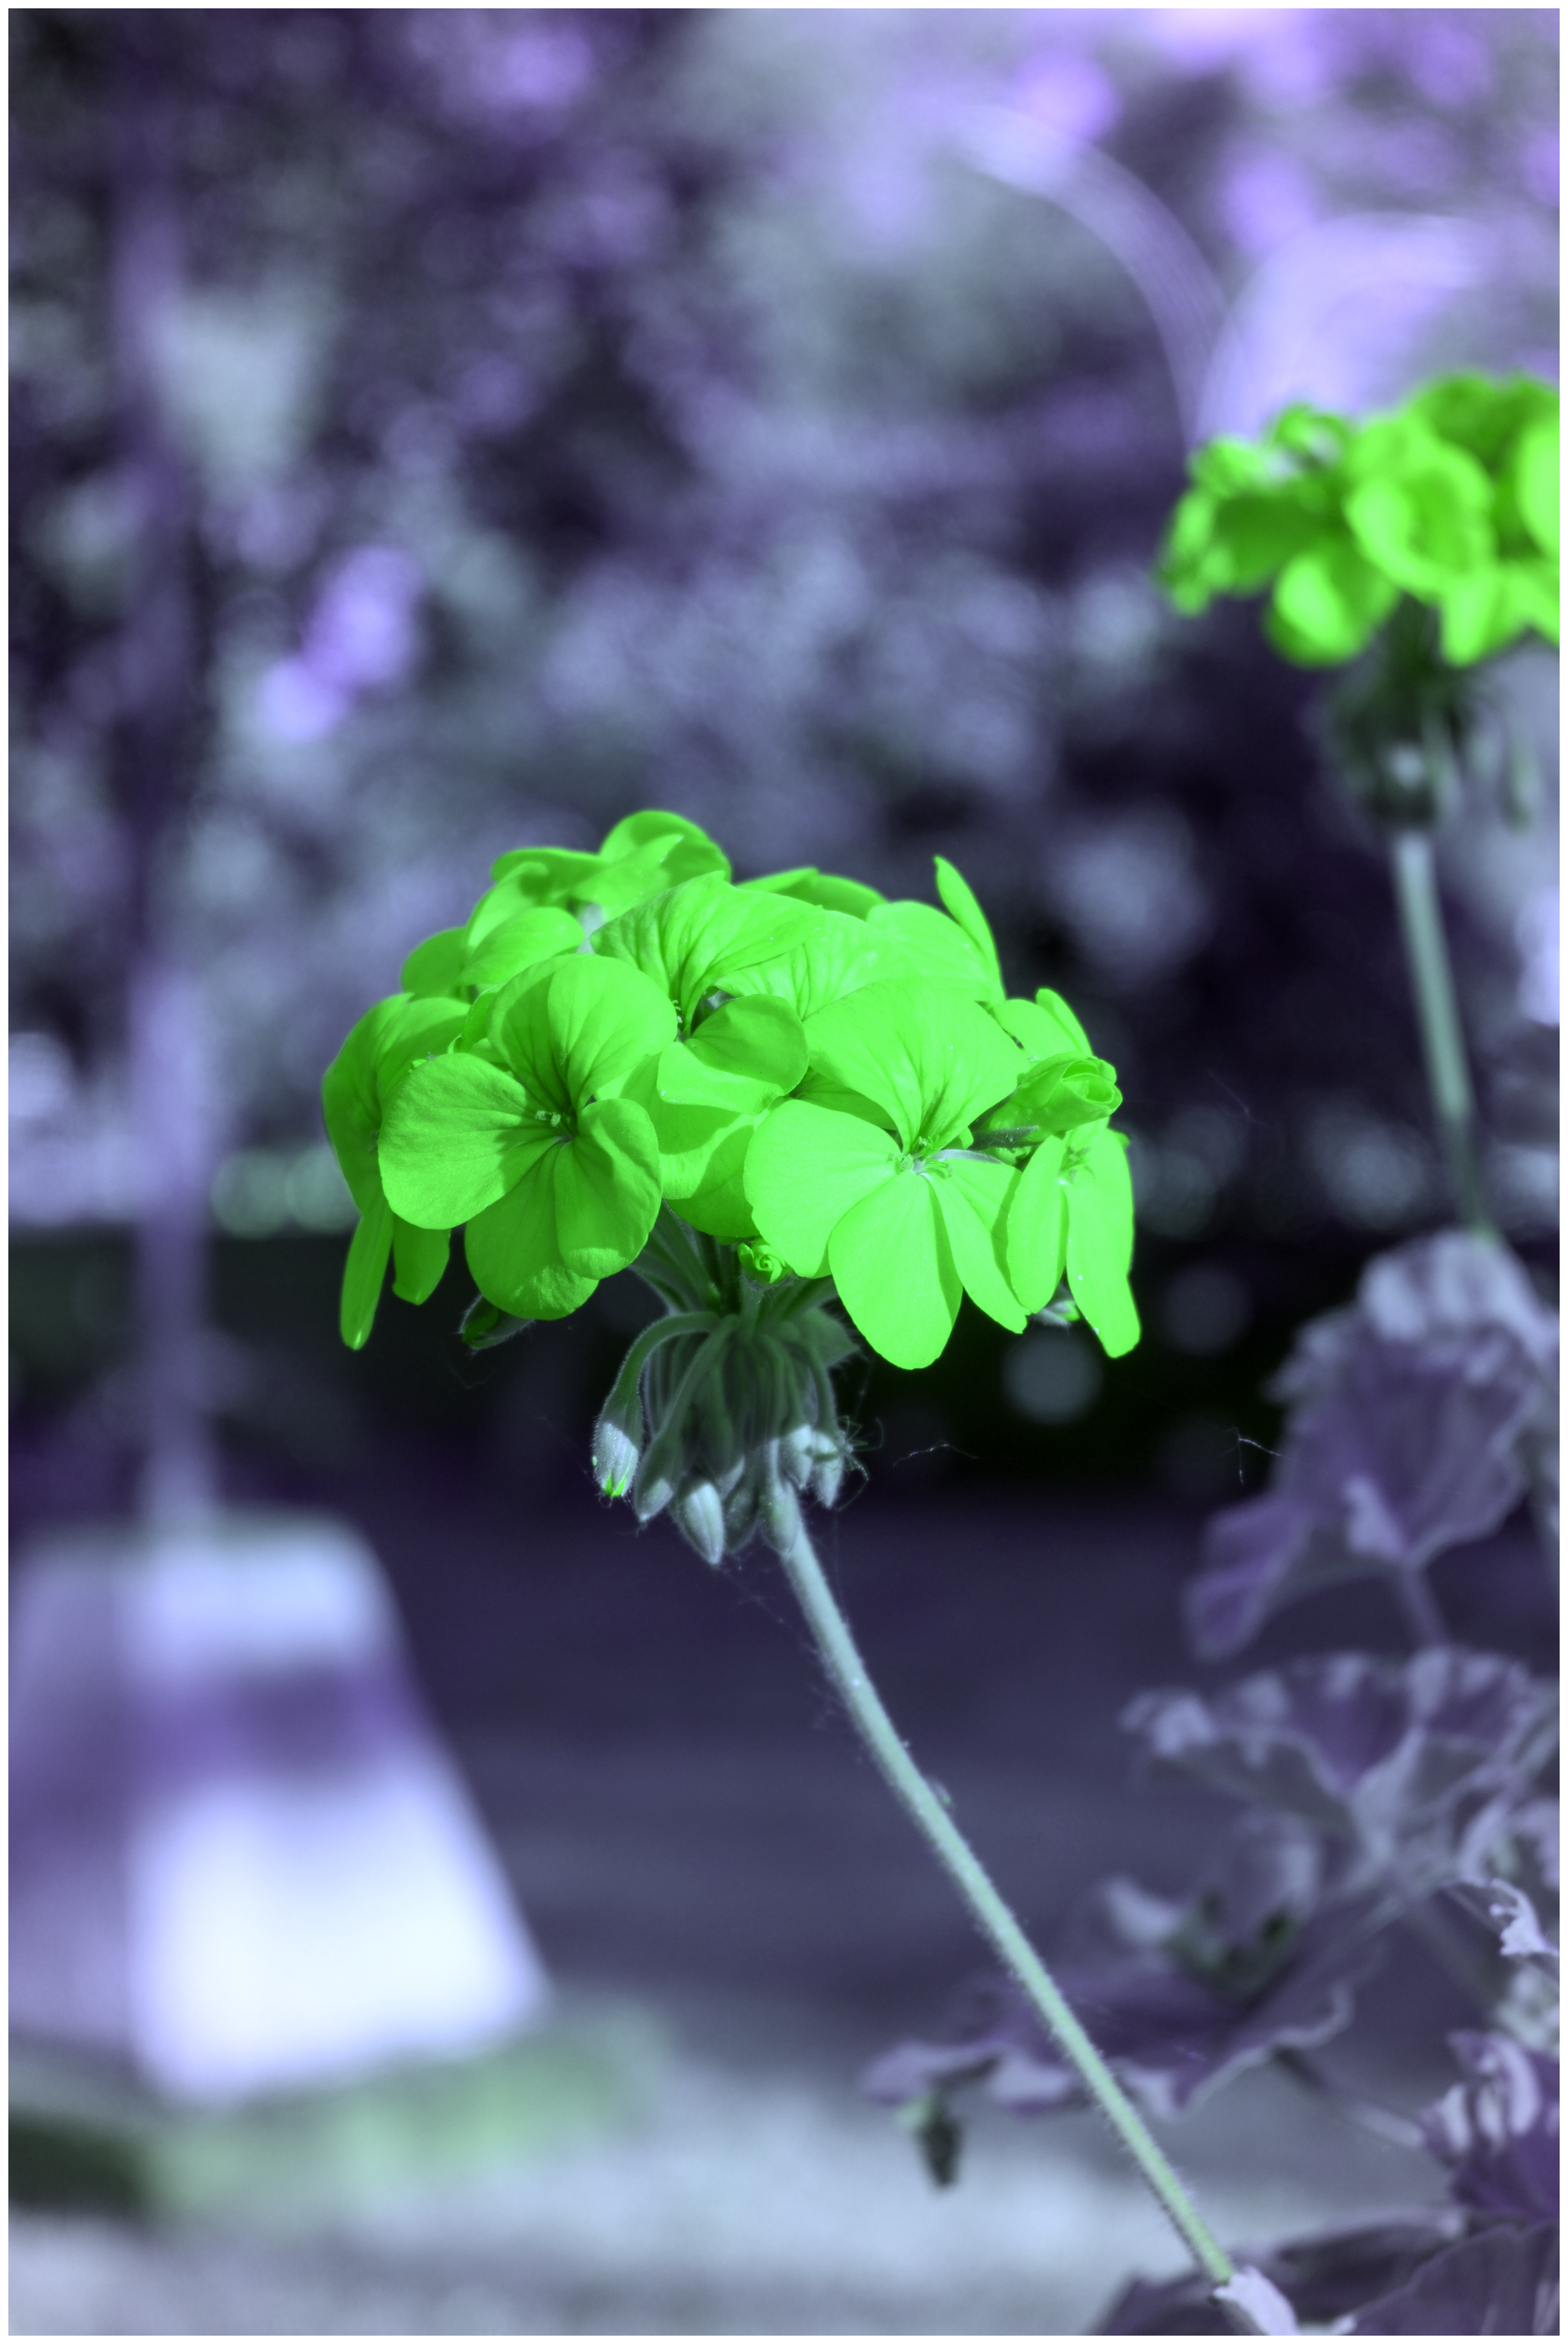

In [13]:
file = '_DSC1374.jpg'
image = Image.open(f'images/originals/{file}')
image = image.convert('RGB')
rgb_channels = np.array(image)
rgb_trans = [red_rgb_trans, green_rgb_trans, blue_rgb_trans]

pixels_trans = transform_pixels(rgb_channels, rgb_trans)
fig, ax = plt.subplots(figsize=(width / 200, height / 200))
ax.imshow(pixels_trans)
ax.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
folder = 'blueshifted' if beta < 0 else 'redshifted'
plt.savefig(f'images/{folder}/alpha={int(np.degrees(angle_of_view))}°_beta={beta}_{file}', bbox_inches='tight', pad_inches=0)
plt.show()

In [86]:
import numpy as np
import colour
from scipy.interpolate import interp1d

# Create theta array based on height, width, and angle of view
def create_theta_array(height, width, angle_of_view):
    x = np.arange(-width // 2, width // 2)
    y = np.arange(-height // 2, height // 2)
    z = np.sqrt(x[-1]**2 + y[-1]**2) / np.tan(angle_of_view)
    X, Y = np.meshgrid(x, y)
    return np.arctan(np.sqrt(X**2 + Y**2) / z)

# Transform theta based on beta and theta
def transform_theta(THETA, beta):
    return 2 * np.arctan(np.sqrt((1 + beta) / (1 - beta)) * np.tan(THETA / 2))

# Map the pixels from original theta to new theta
def map_pixels_to_new_theta(rgb_channels, THETA, THETA_transformed):
    height, width, _ = rgb_channels.shape
    X = np.sin()
    # Flatten arrays for interpolation
    original_theta_flat = THETA.flatten()
    transformed_theta_flat = THETA_transformed.flatten()
    
    # Perform interpolation for each color channel
    rgb_mapped = np.zeros_like(rgb_channels)
    for i in range(3):  # For each channel (R, G, B)
        channel_flat = rgb_channels[:, :, i].flatten()
        # Create an interpolation function
        interp_func = interp1d(original_theta_flat, channel_flat, kind='linear', bounds_error=False, fill_value=0)
        # Map to transformed theta
        new_channel_flat = interp_func(transformed_theta_flat)
        rgb_mapped[:, :, i] = new_channel_flat.reshape(height, width)
    
    return rgb_mapped

# Transform wavelength using beta and THETA (kept for reference)
def transform_wavelength(wavelength, beta, THETA):
    gamma = 1 / np.sqrt(1 - beta ** 2)
    return wavelength / (gamma * (1 - beta * np.cos(THETA)))

# Convert wavelength to RGB values (in range 0-1)
def wavelength_to_rgb(wavelength):
    visible_wavelength = np.clip(wavelength, 380, 750)
    xyz = colour.wavelength_to_XYZ(visible_wavelength)
    rgb = colour.XYZ_to_sRGB(xyz)
    return np.clip(rgb, 0, 1)

# Transform pixels using the mapped RGB channels
def transform_pixels(rgb_channels, rgb_trans):
    pixels_trans = 0
    for i in range(3):
        pixels_trans += rgb_trans[i] * rgb_channels[:, :, i][..., np.newaxis]
    return pixels_trans.astype(int)


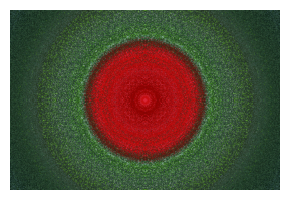

In [87]:
# Use the same parameters as before
angle_of_view = np.radians(40)
beta = -0.15
red_wavelength, green_wavelength, blue_wavelength = 644, 515, 467.83
height, width = 360, 540

# Step 1: Create original theta array
THETA = create_theta_array(height, width, angle_of_view)

# Step 2: Transform theta array based on beta
THETA_transformed = transform_theta(THETA, beta)

# Step 3: Transform the wavelengths using the original theta array
red_wavelength_trans = transform_wavelength(red_wavelength, beta, THETA)
green_wavelength_trans = transform_wavelength(green_wavelength, beta, THETA)
blue_wavelength_trans = transform_wavelength(blue_wavelength, beta, THETA)

# Step 4: Convert the transformed wavelengths to RGB
red_rgb_trans = wavelength_to_rgb(red_wavelength_trans)
green_rgb_trans = wavelength_to_rgb(green_wavelength_trans)
blue_rgb_trans = wavelength_to_rgb(blue_wavelength_trans)

# Step 5: Open the image and extract the RGB channels
file = 'roses.jpeg'
image = Image.open(f'images/originals/{file}')
image = image.convert('RGB')
rgb_channels = np.array(image)

# List of transformed RGB values
rgb_trans = [red_rgb_trans, green_rgb_trans, blue_rgb_trans]

# Step 6: Map the original pixel values to their new theta positions
# This applies the mapping based on the transformed theta array
pixels_mapped = map_pixels_to_new_theta(rgb_channels, THETA, THETA_transformed)

# Step 7: Display and save the transformed image
fig, ax = plt.subplots(figsize=(width / 200, height / 200))
ax.imshow(pixels_mapped)
ax.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Folder name based on beta
folder = 'blueshifted' if beta < 0 else 'redshifted'

# Save the transformed image
plt.savefig(f'images/{folder}/alpha={int(np.degrees(angle_of_view))}°_beta={beta}_{file}', bbox_inches='tight', pad_inches=0)
plt.show()